In [1]:
import os, gc, torch, PIL, pickle

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from utils.plot import plot_losses, plot_train_val_ap_ars
from PIL import Image
from models.load import get_model_label, get_model_name, get_current_epoch, get_dataset_label, get_trained_model

from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS

import utils.print as print_f
from utils.init import reproducibility, clean_memory_get_device

# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class TrainedModels(Enum):

    with_clinical = "val_ar_0_7430_ap_0_5567_test_ar_0_7974_ap_0_5392_epoch29_WithClincal_05-02-2022 17-07-17_with_clinical"

    with_clinical_final = "val_ar_0_7269_ap_0_4601_test_ar_0_6710_ap_0_4286_epoch100_WithClincal_05-02-2022 19-03-30_with_clinical"

    without_clinical = "val_ar_0_5377_ap_0_2981_test_ar_0_4515_ap_0_2716_epoch30_WithoutClincal_05-02-2022 12-32-56_without_clinical"
    without_clinical_final = "val_ar_0_5053_ap_0_2754_test_ar_0_4265_ap_0_2605_epoch100_WithoutClincal_05-02-2022 14-17-08_without_clinical"



In [4]:
naming_map = {
    TrainedModels.with_clinical: "with_clinical_best",
    TrainedModels.with_clinical_final: "with_clinical_final",
    TrainedModels.without_clinical: "without_clinical_best",
    TrainedModels.without_clinical_final: "without_clinical_final",
}


In [13]:
def get_thrs_evaluation_df(models: List[TrainedModels] , dataset, disease="all", thrs = 0.5,):
    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{dataset}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data

    return  pd.DataFrame(
            [
                {
                    "model": str(select_model).split(".")[-1],
                    **all_models_eval_data[select_model.value][thrs][0],
                } for select_model in models
            ]
        )[['model','ap', 'ar']]

In [6]:
# from models.load import TrainedModels
from typing import List

def plot_iou_result_old(models: List[TrainedModels] , datasets, disease="all", figsize=(10, 10), include_recall=False):

    cm = plt.get_cmap('rainbow')
    NUM_COLORS = len(models)

    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{datasets}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data


    fig, (precision_ax, recall_ax) = plt.subplots(
        2, figsize=figsize, dpi=80, sharex=True,
    )

    fig.suptitle(f"{datasets}")

    precision_ax.set_title("Average Precision")
    precision_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for select_model in models:
        precision_ax.plot(
            all_models_eval_data[select_model.value].keys(),
            [v[0]["ap"] for v in all_models_eval_data[select_model.value].values()],
            marker="o",
            label=get_model_label(select_model, naming_map=naming_map),
            # color="darkorange",
        )
    precision_ax.legend(loc="upper right")

    recall_ax.set_title("Average Recall")
    recall_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    for select_model in models:
        recall_ax.plot(
            all_models_eval_data[select_model.value].keys(),
            [v[0]["ar"] for v in all_models_eval_data[select_model.value].values()],
            marker="o",
            label=get_model_label(select_model, naming_map=naming_map),
            # color="darkorange",
        )

    recall_ax.legend(loc="upper right")
    recall_ax.set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig

In [31]:
# from models.load import TrainedModels
from typing import List

def plot_iou_result(
    models: List[TrainedModels],
    datasets,
    disease="all",
    figsize=(10, 10),
    include_recall=False,
):

    cm = plt.get_cmap("rainbow")
    NUM_COLORS = len(models)

    all_models_eval_data = { dataset: {} for dataset in datasets}

    for select_model in models:
        for dataset in datasets:
            with open(
                os.path.join(
                    "eval_results", f"{select_model.value}_{dataset}_{disease}.pkl",
                ),
                "rb",
            ) as f:
                eval_data = pickle.load(f)
                all_models_eval_data[dataset][select_model.value] = eval_data

    fig, axes = plt.subplots(
        len(datasets), 2 if include_recall else 1,
        figsize=figsize,
        dpi=80,
        sharex=True,
        squeeze=False
    )

    for i, dataset in enumerate(datasets):
        axes[i,0].set_title(f"[{dataset}] - Average Precision")
        axes[i,0].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for select_model in models:
            axes[i,0].plot(
                all_models_eval_data[dataset][select_model.value].keys(),
                [v[0]["ap"] for v in all_models_eval_data[dataset][select_model.value].values()],
                marker="o",
                label=get_model_label(select_model, naming_map=naming_map),
                # color="darkorange",
            )
        axes[i,0].legend(loc="lower left")

        if (include_recall):

            axes[i, 1].set_title(f"[{dataset}] - Average Recall")
            axes[i, 1].set_prop_cycle(
                "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
            )

            for select_model in models:
                axes[i, 1].plot(
                    all_models_eval_data[dataset][select_model.value].keys(),
                    [v[0]["ar"] for v in all_models_eval_data[dataset][select_model.value].values()],
                    marker="o",
                    label=get_model_label(select_model, naming_map=naming_map),
                    # color="darkorange",
                )

            axes[i, 1].legend(loc="lower left")
            axes[i, 1].set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


In [33]:
def showModelOnDatasets(
    select_model, datasets, disease="all", figsize=(10, 10), include_recall=False
):
    """
    This function used for detecting the overfitting dataset.    
    """
    cm = plt.get_cmap("gist_rainbow")
    NUM_COLORS = len(datasets)

    all_models_eval_data = {}
    for dataset in datasets:
        with open(
            os.path.join(
                "eval_results", f"{select_model.value}_{dataset}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[dataset] = eval_data

    fig, axes = plt.subplots(
        2 if include_recall else 1, figsize=figsize, dpi=80, sharex=True, squeeze=False,
    )

    axes = axes[0]

    fig.suptitle(get_model_label(select_model, naming_map=naming_map))

    axes[0].set_title("Average Precision")
    axes[0].set_prop_cycle(
        "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
    )

    for dataset in datasets:
        axes[0].plot(
            all_models_eval_data[dataset].keys(),
            [v[0]["ap"] for v in all_models_eval_data[dataset].values()],
            marker="o",
            label=dataset,
            # color="darkorange",
        )
    axes[0].legend(loc="lower left")

    if include_recall:
        axes[1].set_title("Average Recall")
        axes[1].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for dataset in datasets:
            axes[1].plot(
                all_models_eval_data[dataset].keys(),
                [v[0]["ar"] for v in all_models_eval_data[dataset].values()],
                marker="o",
                label=dataset,
                # color="darkorange",
            )

        axes[1].legend(loc="lower left")
        axes[1].set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


In [9]:
def plot_training_progress(trained_models):
    for trained_model in trained_models:
        _, train_info, _ = get_trained_model(
            trained_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.05,
        )

        print_f.print_title("Training Info")
        print(train_info)

        plot_train_val_ap_ars(
            train_ap_ars=train_info.train_ap_ars, val_ap_ars=train_info.val_ap_ars,
        )

        plot_losses(train_info.train_data, train_info.val_data)


In [10]:
from utils.train import num_params

def print_num_params(trained_models):
    for trained_model in trained_models:
        model, train_info, _ = get_trained_model(
            trained_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            image_size=512,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.05,
        )

        print(f"| [{train_info.model_setup.name}] | #Params: [{num_params(model):,}] |")


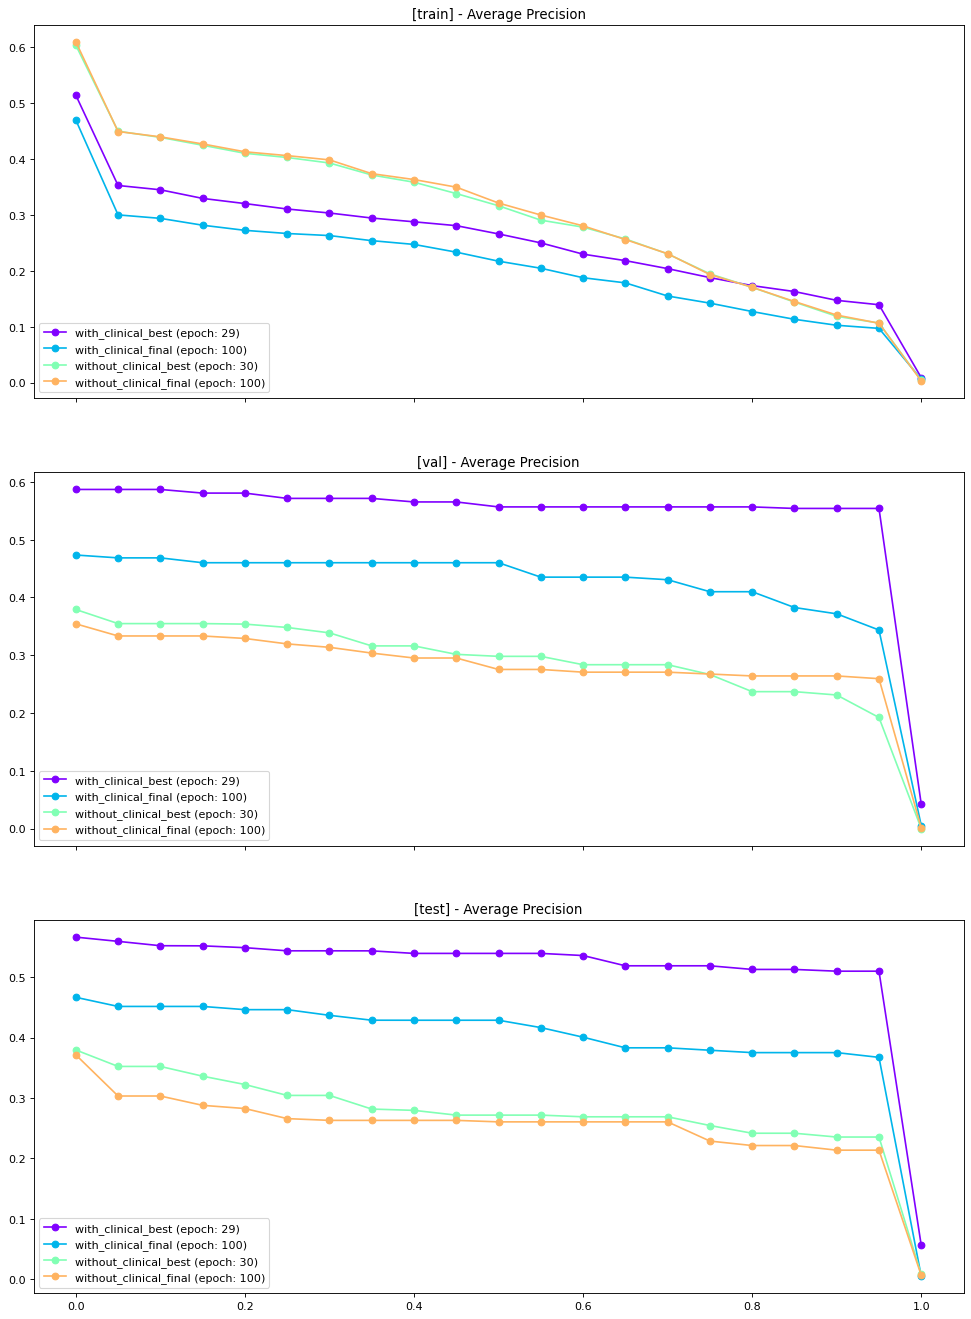

In [32]:
_ = plot_iou_result(
    [
        TrainedModels.with_clinical,
        TrainedModels.with_clinical_final,
        TrainedModels.without_clinical,
        TrainedModels.without_clinical_final,
    ],
    ["train", "val", "test"],
    figsize=(15, 21),
    include_recall=False,
)


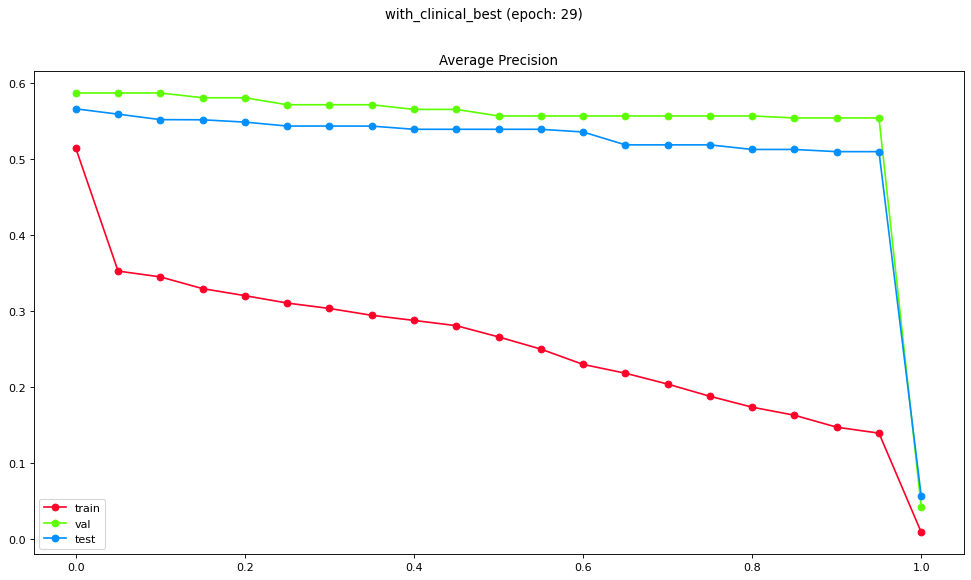

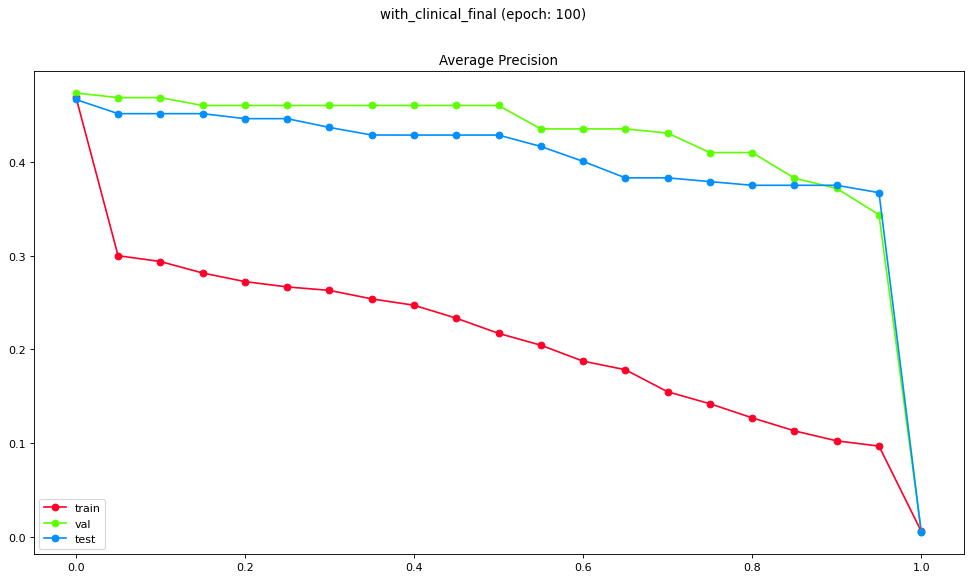

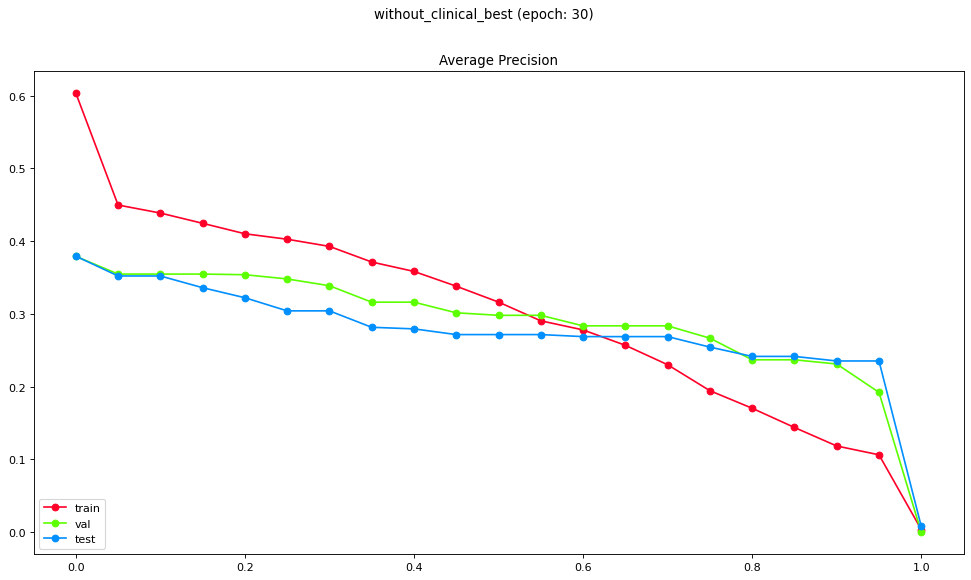

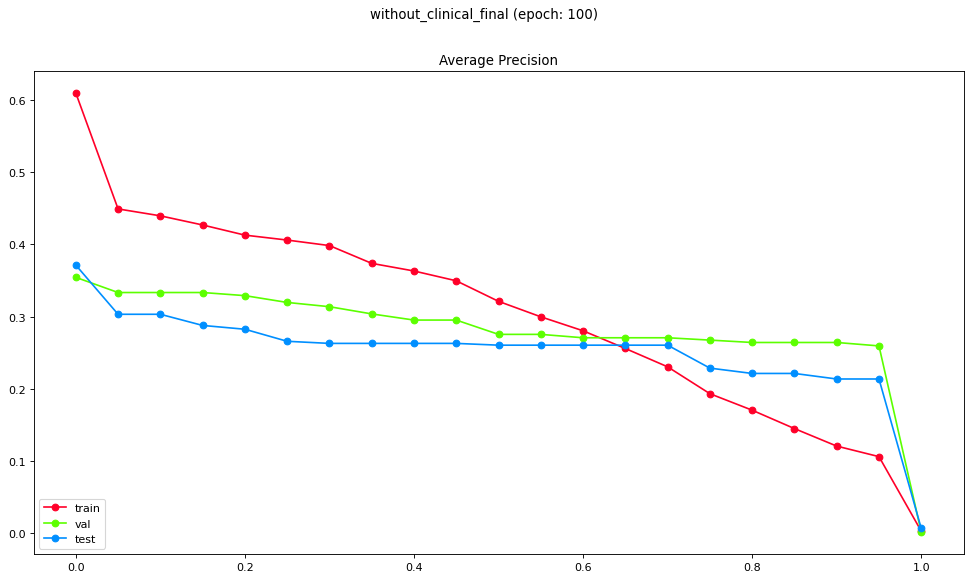

In [34]:
for model in [
    TrainedModels.with_clinical,
    TrainedModels.with_clinical_final,
    TrainedModels.without_clinical,
    TrainedModels.without_clinical_final,
]:
    _ = showModelOnDatasets(model, ["train", "val", "test"], figsize=(15, 8))

In [14]:
get_thrs_evaluation_df(
    [
        TrainedModels.with_clinical,
        TrainedModels.with_clinical_final,
        TrainedModels.without_clinical,
        TrainedModels.without_clinical_final,
    ],
    "val",
)


,model,ap,ar
0,with_clinical,0.556732,0.742990
1,with_clinical_final,0.460137,0.726884
2,without_clinical,0.298109,0.537740
3,without_clinical_final,0.275427,0.505273


In [19]:
all_datasets = ['train', 'val', 'test', 'our']
all_diseases = DEFAULT_REFLACX_LABEL_COLS + ['all']

In [22]:
for dataset in all_datasets:
    print_f.print_block(f"{dataset} dataset")
    for disease in all_diseases:
        print_f.print_title(disease)
        display(get_thrs_evaluation_df(
            [
                TrainedModels.with_clinical,
                # TrainedModels.with_clinical_final,
                TrainedModels.without_clinical,
                # TrainedModels.without_clinical_final,
            ],
            dataset,
            disease=disease
        ))



| train dataset 
====================Enlarged cardiac silhouette====================


,model,ap,ar
0,with_clinical,0.609896,0.798387
1,without_clinical,0.664666,0.790323


====================Atelectasis====================


,model,ap,ar
0,with_clinical,0.278086,0.629630
1,without_clinical,0.255339,0.530864


====================Pleural abnormality====================


,model,ap,ar
0,with_clinical,0.199208,0.452381
1,without_clinical,0.136294,0.428571


====================Consolidation====================


,model,ap,ar
0,with_clinical,0.036855,0.388060
1,without_clinical,0.052523,0.313433


====================Pulmonary edema====================


,model,ap,ar
0,with_clinical,0.203543,0.524752
1,without_clinical,0.383754,0.732673


====================all====================


,model,ap,ar
0,with_clinical,0.265918,0.570745
1,without_clinical,0.316292,0.564440



| val dataset 
====================Enlarged cardiac silhouette====================


,model,ap,ar
0,with_clinical,0.840842,0.909091
1,without_clinical,0.650292,0.909091


====================Atelectasis====================


,model,ap,ar
0,with_clinical,0.564646,0.833333
1,without_clinical,0.208141,0.444444


====================Pleural abnormality====================


,model,ap,ar
0,with_clinical,0.835574,0.928571
1,without_clinical,0.145468,0.500000


====================Consolidation====================


,model,ap,ar
0,with_clinical,0.194509,0.428571
1,without_clinical,0.021216,0.142857


====================Pulmonary edema====================


,model,ap,ar
0,with_clinical,0.348091,0.615385
1,without_clinical,0.465427,0.692308


====================all====================


,model,ap,ar
0,with_clinical,0.556732,0.74299
1,without_clinical,0.298109,0.53774



| test dataset 
====================Enlarged cardiac silhouette====================


,model,ap,ar
0,with_clinical,0.704020,0.736842
1,without_clinical,0.484657,0.578947


====================Atelectasis====================


,model,ap,ar
0,with_clinical,0.710442,1.000000
1,without_clinical,0.246315,0.428571


====================Pleural abnormality====================


,model,ap,ar
0,with_clinical,0.763298,0.875
1,without_clinical,0.112294,0.250


====================Consolidation====================


,model,ap,ar
0,with_clinical,0.151491,0.750
1,without_clinical,0.230723,0.375


====================Pulmonary edema====================


,model,ap,ar
0,with_clinical,0.366566,0.625
1,without_clinical,0.284201,0.625


====================all====================


,model,ap,ar
0,with_clinical,0.539163,0.797368
1,without_clinical,0.271638,0.451504



| our dataset 
====================Enlarged cardiac silhouette====================


,model,ap,ar
0,with_clinical,0.653662,0.791667
1,without_clinical,0.047255,0.208333


====================Atelectasis====================


,model,ap,ar
0,with_clinical,0.172290,0.888889
1,without_clinical,0.020702,0.222222


====================Pleural abnormality====================


,model,ap,ar
0,with_clinical,0.583427,0.777778
1,without_clinical,0.230363,0.388889


====================Consolidation====================


,model,ap,ar
0,with_clinical,0.285119,0.500000
1,without_clinical,0.185269,0.285714


====================Pulmonary edema====================


,model,ap,ar
0,with_clinical,0.231023,0.375
1,without_clinical,0.000000,0.000


====================all====================


,model,ap,ar
0,with_clinical,0.385104,0.666667
1,without_clinical,0.096718,0.221032
